In [1]:
import time

import numpy as np
import matplotlib.pyplot as plt
import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp

tfb = tfp.bijectors
tfd = tfp.distributions
tfk = tfp.math.psd_kernels
tf.enable_v2_behavior()

from tensorflow_probability.python.math.psd_kernels.internal import util
from typing import List

# Configure plot defaults
plt.rcParams["axes.facecolor"] = "white"
plt.rcParams["grid.color"] = "#666666"

In [2]:
import arviz as az

az.style.use("arviz-viridish")


In [3]:
np.random.seed(20)

## Prepare Power Spectrum data

Power spectrum, P(k), is the Fourier Transform of the correlation function in the Universe. It describes the variance of the matter density field as a function of k. k is in unit of inverse length, which means small k describes longer distances and large k describes shorter distances. Thus, large P(k) at large k means there are more structures (more variance) at the large scales (longer distances).

Below, we use the power spectrum from dark-matter only simulations.


In [4]:
# Fourier k modes
kf = np.loadtxt(
    "../data/Matterpower_60_res128box256_3_res512box256_z0_ind-0-1-2/kf.txt"
)

# X is the input cosmological parameters, (Omega_m, Omega_0, h, A_s, n_s)
X_l = np.loadtxt(
    "../data/Matterpower_60_res128box256_3_res512box256_z0_ind-57-58-59/train_input_fidelity_0.txt"
)
X_h = np.loadtxt(
    "../data/Matterpower_60_res128box256_3_res512box256_z0_ind-57-58-59/train_input_fidelity_1.txt"
)
# lower and upper bounds (prior volume) of the cosmological parameters
param_limits = np.loadtxt(
    "../data/Matterpower_60_res128box256_3_res512box256_z0_ind-57-58-59/input_limits.txt"
)

# Y is the power spectrum, P(k)
Y_l = np.loadtxt(
    "../data/Matterpower_60_res128box256_3_res512box256_z0_ind-57-58-59/train_output_fidelity_0.txt"
)
Y_h = np.loadtxt(
    "../data/Matterpower_60_res128box256_3_res512box256_z0_ind-57-58-59/train_output_fidelity_1.txt"
)

# Test set
X_test = np.loadtxt(
    "../data/Matterpower_60_res128box256_3_res512box256_z0_ind-57-58-59/test_input.txt"
)
Y_test = np.loadtxt(
    "../data/Matterpower_60_res128box256_3_res512box256_z0_ind-57-58-59/test_output.txt"
)

In [5]:
!ls ../data/Matterpower_60_res128box256_3_res512box256_z0_ind-0-1-2

input_limits.txt            train_input_fidelity_0.txt
kf.txt                      train_input_fidelity_1.txt
test_input.txt              train_output_fidelity_0.txt
test_output.txt             train_output_fidelity_1.txt


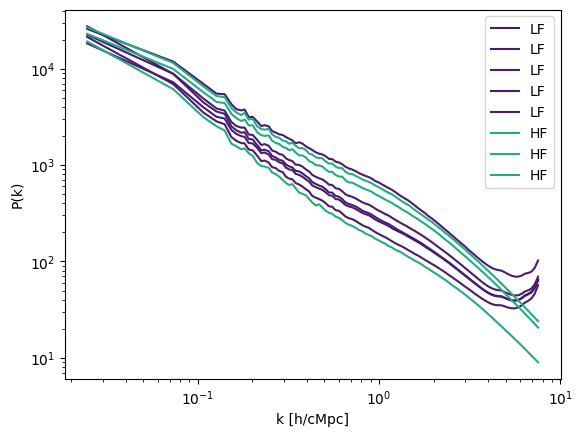

In [6]:
plt.loglog(10**kf, 10 ** Y_l[:5, :].T, color="C0", label="LF")
plt.loglog(10**kf, 10 ** Y_h[:3, :].T, color="C2", label="HF")

plt.xlabel("k [h/cMpc]")
plt.ylabel("P(k)")
plt.legend()

It is essential to normalize both the input and outputs. Because we will be using the same LogNormal priors for lengthscales and amplitudes for each parameter and each k bin. We don't want the prior to bias the inferred hyperparameters in a certain dimension of k bin.


In [7]:
def map_to_unit_cube(param_vec, param_limits):
    """
    Map a parameter vector to the unit cube from the original dimensions of the space.
    Arguments:
    param_vec - the vector of parameters to map.
    param_limits - the limits of the allowed parameters.
    Returns:
    vector of parameters, all in [0,1].
    """
    assert (np.size(param_vec), 2) == np.shape(param_limits)
    assert np.all(param_vec - 1e-16 <= param_limits[:, 1])
    assert np.all(param_vec + 1e-16 >= param_limits[:, 0])
    ii = np.where(param_vec > param_limits[:, 1])
    param_vec[ii] = param_limits[ii, 1]
    ii = np.where(param_vec < param_limits[:, 0])
    param_vec[ii] = param_limits[ii, 0]
    assert np.all(param_limits[:, 0] <= param_limits[:, 1])
    new_params = (param_vec - param_limits[:, 0]) / (
        param_limits[:, 1] - param_limits[:, 0]
    )
    assert np.all((new_params >= 0) * (new_params <= 1))
    return new_params


def map_to_unit_cube_list(param_vec_list, param_limits):
    """Map multiple parameter vectors to the unit cube"""
    return np.array(
        [map_to_unit_cube(param_vec, param_limits) for param_vec in param_vec_list]
    )


def input_normalize(params: np.ndarray, param_limits: np.ndarray) -> np.ndarray:
    """
    Map the parameters onto a unit cube so that all the variations are
    similar in magnitude.

    :param params: (n_points, n_dims) parameter vectors
    :param param_limits: (n_dim, 2) param_limits is a list
        of parameter limits.
    :return: params_cube, (n_points, n_dims) parameter vectors
        in a unit cube.
    """
    nparams = np.shape(params)[1]
    params_cube = map_to_unit_cube_list(params, param_limits)
    assert params_cube.shape[1] == nparams

    return params_cube

In [8]:
# Normalize input to a [0 - 1] Latin Hypercube
# This is to avoid the lengthscale & amplitude prior
# to hard to define
X_l = input_normalize(X_l, param_limits=param_limits)
X_h = input_normalize(X_h, param_limits=param_limits)

X_test = input_normalize(X_test, param_limits=param_limits)


Normalizing using mean at HF indeed introduce some bias at small scales (towards negative).

Not normalizing has no issue of that, but the emulator error the amplitude is still high.

- Interesting point: It's because the mean at HF is not at the center of the parameter space,
  and it's not the same parameter point as the LF. There will be some mismatch between LF and HF,
  then making it hard to train. Not totally sure if I will introduce bias or not.


In [9]:
medind = np.argsort(np.mean(Y_h, axis=1))[np.shape(Y_h)[0] // 2]

scalefactors = Y_h[medind, :]
medind

2

In [10]:
medind = np.argsort(np.mean(Y_l, axis=1))[np.shape(Y_l)[0] // 2]

scalefactors_l = Y_l[medind, :]
scalefactors
medind

20

In [11]:
# [L fidelity]
# Normalized: Here we substract the P(k) with its mean at a certain k,
# P(k= k') <- P(k= k') - Mean(P(k = k'))
Y_l_mean = np.mean(Y_l, axis=0)
_Y_l_old = Y_l
Y_l = Y_l - Y_l_mean

# [H fidelity]
# Y_h_mean = np.mean(Y_h, axis=0)
_Y_h_old = Y_h
Y_h = Y_h  # - Y_h_mean

# [Test H fidelity]
_Y_test_old = Y_test
Y_test = Y_test  # - Y_h_mean

# The transpose here is to fit the convention of tensorflow, which wants Y in dimension of
# (num of outputs, num of examples)
Y_l = Y_l.T
Y_h = Y_h.T
Y_test = Y_test.T

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


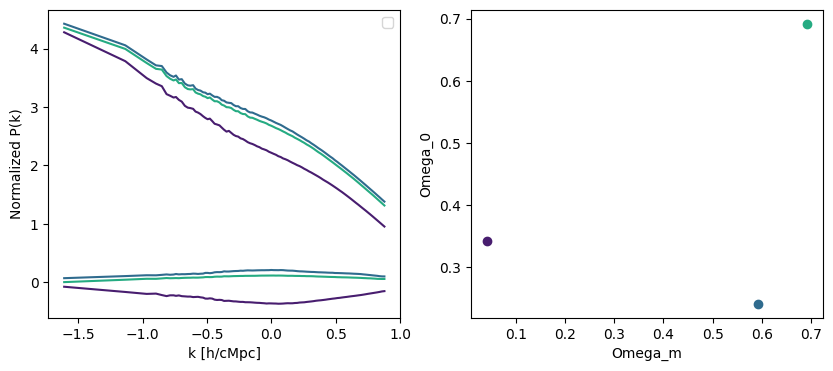

In [12]:
# preview the first 4 simulations
# also plot the input parameters in ith and jth dimension

#### Changable: Choice of two-dim projection of parameters ####
param_i = 0  # choose 0 ~ 8
param_j = 1  # choose 0 ~ 8
###############################################################

param_names = ["Omega_m", "Omega_0", "h", "A_s", "n_s"]

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

for k in range(3):
    ax[0].plot(kf, Y_l[:, 57 + k], color="C{}".format(k))

    # view the input X with the corresponding colors
    ax[1].plot(
        X_l[57 + k, param_i],
        X_l[57 + k, param_j],
        ls="",
        marker="o",
        color="C{}".format(k),
    )

    ax[0].plot(
        kf,
        Y_h[:, k],
        color="C{}".format(k),
    )


ax[0].set_xlabel("k [h/cMpc]")
ax[0].set_ylabel("Normalized P(k)")

ax[1].set_xlabel(param_names[param_i])
ax[1].set_ylabel(param_names[param_j])

ax[0].legend()


In [13]:
# the convention of tensorflow:
#  number_examples : number of training simulations
#  number_features : number of parameters you have in input space
#  number_outputs  : number of bins you have in output space
num_examples_l, num_features_l = X_l.shape
num_outputs_l, num_examples_l = Y_l.shape

print("LF", num_examples_l, num_features_l, num_outputs_l)

num_examples_h, num_features_h = X_h.shape
num_outputs_h, num_examples_h = Y_h.shape

print("HF", num_examples_h, num_features_h, num_outputs_h)


LF 60 5 96
HF 3 5 96


## Build your GP with TensorFlow

We want our GP to have different hyperparameters for different feature dimensions. There are 9 dimensions in the input space, and we want our GP's covariance function behaves differently in a different dimension.

Assigning different hyperparameters for each dimension is also called Automatic Relevance Determination (ARD) in the GP community. If we use a standard Exponiated Quadratic (also called Radial Basis or Squared Exponential) kernel, ARD will assign one lengthscale per feature dimension (9 lengthscales in our case).

ARD can be applied through [`FeatureScaled`](https://www.tensorflow.org/probability/api_docs/python/tfp/math/psd_kernels/FeatureScaled) kernel in Tensflow probability.

```python
tfp.math.psd_kernels.FeatureScaled(
 kernel,
 scale_diag=None,
 inverse_scale_diag=None,
 validate_args=False,
 name='FeatureScaled'
)
```

> Given a kernel `K` and `scale_diag` and inputs `x` and `x'`, this kernel first rescales the input by computing `x / scale_diag` and `x' / scale_diag`, and passing this to `K`.

$$
K ← K(\frac{x}{\lambda}, \frac{x'}{\lambda})
$$


### Choose your kernels

As mentioned before, the outcomes of the simulation code are assumed to be sampled from an emulator, $f$:

$$
f \sim \textsf{GaussianProcess}\left(0, \text{covariance_fn}=k(x, x')\right).
$$

The only thing left to be learned from the training set is the covariance function, $k(x, x')$.

Here we choose the most common GP kernel, ExponentiatedQuadratic (also called Radial Basis or Gaussian kernel) covariance kernel:

$$
k(x, x') = \sigma^2 \exp \left( \frac{\|x - x'\|^2}{\lambda^2} \right),
$$

- $\sigma^2$: the variance, it is called **amplitude** in TFP.
- $\lambda$: the lengthscale.


## Multi-fidelity with Non-linear Autoregressive Model

We could define a new kernel class to incorporate two kernels


Here we build two GPs, while passing the 1st GP's output to the second GP.


In [14]:
class ActiveDimension(tfk.FeatureTransformed):
    def __init__(
        self,
        kernel,
        active_dim: List,
        validate_args=False,
        parameters=None,
        name="ActiveDim",
    ) -> None:
        self._transformation_fn = (
            lambda x, feature_ndims, param_expansion_ndims: tf.gather(
                x,
                active_dim,
                axis=-1,
            )
        )

        super(ActiveDimension, self).__init__(
            kernel=kernel,
            transformation_fn=self._transformation_fn,
            validate_args=validate_args,
            parameters=parameters,
            name=name,
        )

        # Keep the kernel so that we can get the batch shape
        self._kernel = kernel

    @property
    def batch_shape(self):
        return self._kernel.batch_shape

    def batch_shape_tensor(self):
        return self._kernel.batch_shape_tensor

In [15]:
n_input_dims = num_features_h
# although we have multiple bins, bins should be in num_outputs dim, not features
n_output_dim = 1
base_dims_list = list(range(n_input_dims))
out_dims_list = list(range(n_input_dims, n_input_dims + n_output_dim))


In [16]:
def get_lf_kernel(amplitude, length_scale):
    """
    SE kernel with ARD
    """
    # Create the covariance kernel, which will be shared between the prior (which we
    # use for maximum likelihood training) and the posterior (which we use for
    # posterior predictive sampling)
    se_kernel = tfk.ExponentiatedQuadratic(amplitude)
    # this is our ARD kernel, with 1 lengthscale per feature dim.
    # we use scale_diag to represent the lengthscales.
    kernel = tfk.FeatureScaled(
        se_kernel,
        scale_diag=length_scale,
    )

    return kernel


def get_nargp_kernel(
    scale_amplitude_0,  # HF
    scale_length_scale_0,  # HF
    interaction_amplitude_0,  # HF
    interaction_length_scale_0,  # HF
    bias_amplitude_0,  # HF
    bias_length_scale_0,  # HF
    linear_bias_amplitude_0,  # HF
    linear_slope_amplitude_0,  # HF
    linear_shift_0,
):
    # HF kernel
    scale_kernel = ActiveDimension(
        tfk.ExponentiatedQuadratic(scale_amplitude_0, scale_length_scale_0),
        active_dim=out_dims_list,
    )
    scale_kernel += ActiveDimension(
        tfk.Linear(
            bias_amplitude=linear_bias_amplitude_0,
            slope_amplitude=linear_slope_amplitude_0,
            shift=linear_shift_0,
        ),
        active_dim=out_dims_list,
    )
    # scale_kernel += ActiveDimension(
    #     tfk.Linear(
    #         bias_amplitude=None,
    #         slope_amplitude=linear_slope_amplitude_0,
    #         shift=None,
    #     ),
    #     active_dim=out_dims_list,
    # )
    interaction_kernel = ActiveDimension(
        tfk.ExponentiatedQuadratic(interaction_amplitude_0, interaction_length_scale_0),
        active_dim=base_dims_list,
    )
    bias_kernel = ActiveDimension(
        tfk.ExponentiatedQuadratic(bias_amplitude_0, bias_length_scale_0),
        active_dim=base_dims_list,
    )
    # NARGP kernel
    kernel_h = interaction_kernel * scale_kernel + bias_kernel

    return kernel_h

In [17]:
def make_nargp_index_points(m1, X_h, num_outputs_h):
    # Index points for H include [X, mean from L1]
    # ---
    # Shape : [num_examples_h, num_features_h]
    ## -> [num_outputs, num_examples_h, num_features_h]
    _x_h_repeat = tf.repeat(X_h[None, :, :], num_outputs_h, axis=0)
    # Shape : [num_outputs, num_examples_h]
    ## -> [num_outputs, num_examples_h, 1]
    _m1 = m1[:, :, None]
    # Index point for NARGP
    index_points_h = tf.concat([_x_h_repeat, _m1], axis=2)
    return index_points_h


- The LogNormal prior on the NARGP kernel affects a lot the results.

- The training is quite sensitive to the prior choice I think it's due to the lack of data.

- Now I shifted to use Uniform, and it turns to a better constrain.

- Note that it's possible to turn on ARD and not messing up the overall performance due to
  the prior constraint.

- Lots of hyperparameters in the NARGP are not useful, turns out the prior range needs
  to be expanded to make some hyperparameters useless


In [18]:
def build_gp_lf(amplitude, length_scale, observation_noise_variance):
    """
    Low-fidelity:
    Defines the conditional dist. of GP outputs, given kernel parameters.

    X_LF -> GP_LF -> Y_LF

    """
    kernel = get_lf_kernel(amplitude, length_scale)

    # Create the GP prior distribution, which we will use to train the model
    # parameters.
    return tfd.GaussianProcess(
        kernel=kernel,
        index_points=X_l,
        # jibancat: for this example, no need to open the noise
        observation_noise_variance=observation_noise_variance,
    )


def build_gp_nargp(
    scale_amplitude_0,  # HF
    scale_length_scale_0,  # HF
    interaction_amplitude_0,  # HF
    interaction_length_scale_0,  # HF
    bias_amplitude_0,  # HF
    bias_length_scale_0,  # HF
    linear_bias_amplitude_0,  # HF
    linear_slope_amplitude_0,  # HF
    linear_shift_0,
    amplitude_1,  # LF
    length_scale_1,  # LF
    observation_noise_variance_0,
    observation_noise_variance_1,
):
    """
    High-fidelity:
    Defines the conditional dist. of GP outputs, given kernel parameters.

    f_HF = \rho f_LF + \delta

      X_HF -> GP_LF -> f_LF
      X_HF -> GP_HF -> delta_HF
                  -> f_LF * rho + delta_HF
    """
    kernel_h = get_nargp_kernel(
        scale_amplitude_0,  # HF
        scale_length_scale_0,  # HF
        interaction_amplitude_0,  # HF
        interaction_length_scale_0,  # HF
        bias_amplitude_0,  # HF
        bias_length_scale_0,  # HF
        linear_bias_amplitude_0,  # HF
        linear_slope_amplitude_0,  # HF
        linear_shift_0,
    )
    # LF kernel
    kernel_l1 = get_lf_kernel(amplitude_1, length_scale_1)

    ## Mean predictions from the LF GP
    gprm_l1 = tfd.GaussianProcessRegressionModel(
        kernel=kernel_l1,
        index_points=X_h,
        observation_index_points=X_l,
        observations=Y_l,
        observation_noise_variance=observation_noise_variance_1,
        predictive_noise_variance=0.0,
    )
    # Shape: [num_outputs, num_examples(index points)]
    m1 = gprm_l1.mean()

    # Index points for H include [X, mean from L1]
    # ---
    # Shape : [num_examples_h, num_features_h]
    ## -> [num_outputs, num_examples_h, num_features_h]
    _x_h_repeat = tf.repeat(X_h[None, :, :], num_outputs_h, axis=0)
    # Shape : [num_outputs, num_examples_h]
    ## -> [num_outputs, num_examples_h, 1]
    _m1 = m1[:, :, None]
    # Index point for NARGP
    index_points_h = tf.concat([_x_h_repeat, _m1], axis=2)

    # Create the GP prior distribution, which we will use to train the model
    # parameters.
    return tfd.GaussianProcess(
        kernel=kernel_h,
        index_points=index_points_h,
        # jibancat: for this example, no need to open the noise
        observation_noise_variance=observation_noise_variance_0,
    )


gp_joint_model_lf = tfd.JointDistributionNamed(
    {
        "amplitude": tfd.Uniform(
            low=np.ones([num_outputs_l]) * 1e-6,
            high=np.ones([num_outputs_l]) * 1e3,
        ),
        "length_scale": tfd.Independent(
            tfd.Uniform(
                low=np.ones([num_outputs_l, num_features_l]) * 1e-6,
                high=np.ones([num_outputs_l, num_features_l]) * 1e7,
            ),
            reinterpreted_batch_ndims=1,
        ),
        "observation_noise_variance": tfd.Uniform(
            low=np.ones([num_outputs_l]) * 1e-15,
            high=np.ones([num_outputs_l]) * 1e-2,
        ),
        "observations": build_gp_lf,
    }
)

gp_joint_model_hf = tfd.JointDistributionNamed(
    {
        "scale_amplitude_0": tfd.Uniform(
            low=np.ones([num_outputs_h]) * 1e-9,
            high=np.ones([num_outputs_h]) * 1e9,
        ),
        "scale_length_scale_0": tfd.Uniform(
            low=np.ones([num_outputs_h]) * 1e-9,
            high=np.ones([num_outputs_h]) * 1e9,
        ),
        "interaction_amplitude_0": tfd.Uniform(
            low=np.ones([num_outputs_h]) * 1e-9,
            high=np.ones([num_outputs_h]) * 1e9,
        ),
        "interaction_length_scale_0": tfd.Uniform(
            low=np.ones([num_outputs_h]) * 1e-9,
            high=np.ones([num_outputs_h]) * 1e9,
        ),
        "bias_amplitude_0": tfd.Uniform(
            low=np.ones([num_outputs_h]) * 1e-9,
            high=np.ones([num_outputs_h]) * 1e9,
        ),
        "bias_length_scale_0": tfd.Uniform(
            low=np.ones([num_outputs_h]) * 1e-9,
            high=np.ones([num_outputs_h]) * 1e9,
        ),
        "linear_bias_amplitude_0": tfd.Uniform(
            low=np.ones([num_outputs_h]) * 1e-9,
            high=np.ones([num_outputs_h]) * 1e9,
        ),  # linear
        "linear_slope_amplitude_0": tfd.Uniform(
            low=np.ones([num_outputs_h]) * 1e-9,
            high=np.ones([num_outputs_h]) * 1e9,
        ),  # linear
        "linear_shift_0": tfd.Uniform(
            low=np.ones([num_outputs_h]) * -10, high=np.ones([num_outputs_h]) * 10
        ),  # linear
        "amplitude_1": tfd.Uniform(
            low=np.ones([num_outputs_l]) * 1e-9,
            high=np.ones([num_outputs_l]) * 1e9,
        ),
        "length_scale_1": tfd.Independent(
            tfd.Uniform(
                low=np.ones([num_outputs_l, num_features_l]) * 1e-9,
                high=np.ones([num_outputs_l, num_features_l]) * 1e9,
            ),
            reinterpreted_batch_ndims=1,
        ),
        "observation_noise_variance_1": tfd.Uniform(
            low=np.ones([num_outputs_l]) * 1e-15,
            high=np.ones([num_outputs_l]) * 1e-2,
        ),
        "observation_noise_variance_0": tfd.Uniform(
            low=np.ones([num_outputs_h]) * 1e-15,
            high=np.ones([num_outputs_h]) * 1e-2,
        ),
        "observations": build_gp_nargp,
    }
)


In [19]:
# Test the batch shape
gp_joint_model_lf.batch_shape, gp_joint_model_hf.batch_shape


Instructions for updating:
`jitter` is deprecated; please use `marginal_fn` directly.
Instructions for updating:
`always_yield_multivariate_normal` is deprecated. This arg is now ignoredand will be removed after 2023-07-01. A `GaussianProcess` evaluated at asingle index point now always has event shape `[1]` (the previous behaviorfor `always_yield_multivariate_normal=True`). To reproduce the previous behavior of `always_yield_multivariate_normal=False`, squeeze the rightmost singleton dimension from the output of `mean`, `sample`, etc.


Instructions for updating:
`always_yield_multivariate_normal` is deprecated. This arg is now ignoredand will be removed after 2023-07-01. A `GaussianProcessRegressionModel`evaluated at a single index point now always has event shape `[1]` (theprevious behavior for `always_yield_multivariate_normal=True`). Toreproduce the previous behavior of`always_yield_multivariate_normal=False`, squeeze the rightmost singletondimension from the output of `mean`, `sample`, etc.


({'observation_noise_variance': TensorShape([96]),
  'length_scale': TensorShape([96]),
  'amplitude': TensorShape([96]),
  'observations': TensorShape([96])},
 {'scale_length_scale_0': TensorShape([96]),
  'scale_amplitude_0': TensorShape([96]),
  'observation_noise_variance_1': TensorShape([96]),
  'observation_noise_variance_0': TensorShape([96]),
  'linear_slope_amplitude_0': TensorShape([96]),
  'linear_shift_0': TensorShape([96]),
  'linear_bias_amplitude_0': TensorShape([96]),
  'length_scale_1': TensorShape([96]),
  'interaction_length_scale_0': TensorShape([96]),
  'interaction_amplitude_0': TensorShape([96]),
  'bias_length_scale_0': TensorShape([96]),
  'bias_amplitude_0': TensorShape([96]),
  'amplitude_1': TensorShape([96]),
  'observations': TensorShape([96])})

Set the learnable parameters and train based on the maximum marginal likelihoods of two GPs.


In [20]:
# Create the trainable model parameters, which we'll subsequently optimize.
# Note that we constrain them to be strictly positive.
# jibancat: the scale parameter no needs to be positive,
# but I guess it's okay to constrain it to be positive so the delta would
# compensate the sign difference.

constrain_positive = tfb.Shift(np.finfo(np.float64).tiny)(tfb.Exp())

identity = tfb.Identity()

# HF parameters
scale_amplitude_var_0 = tfp.util.TransformedVariable(
    initial_value=np.ones([num_outputs_h]),
    bijector=constrain_positive,
    name="scale_amplitude_0",
    dtype=np.float64,
)
scale_length_scale_var_0 = tfp.util.TransformedVariable(
    initial_value=np.ones([num_outputs_h]),
    bijector=constrain_positive,
    name="scale_length_scale_0",
    dtype=np.float64,
)
interaction_amplitude_var_0 = tfp.util.TransformedVariable(
    initial_value=np.ones([num_outputs_h]),
    bijector=constrain_positive,
    name="interaction_amplitude_0",
    dtype=np.float64,
)
interaction_length_scale_var_0 = tfp.util.TransformedVariable(
    initial_value=np.ones([num_outputs_h]),
    bijector=constrain_positive,
    name="interaction_length_scale_0",
    dtype=np.float64,
)
bias_amplitude_var_0 = tfp.util.TransformedVariable(
    initial_value=np.ones([num_outputs_h]),
    bijector=constrain_positive,
    name="bias_amplitude_0",
    dtype=np.float64,
)
bias_length_scale_var_0 = tfp.util.TransformedVariable(
    initial_value=np.ones([num_outputs_h]),
    bijector=constrain_positive,
    name="bias_length_scale_0",
    dtype=np.float64,
)

# Linear kernel
linear_bias_amplitude_var_0 = tfp.util.TransformedVariable(
    initial_value=np.ones([num_outputs_h]),
    bijector=constrain_positive,
    name="linear_bias_amplitude_0",
    dtype=np.float64,
)
linear_slope_amplitude_var_0 = tfp.util.TransformedVariable(
    initial_value=np.ones([num_outputs_h]),
    bijector=constrain_positive,
    name="linear_slope_amplitude_0",
    dtype=np.float64,
)
linear_shift_var_0 = tfp.util.TransformedVariable(
    initial_value=np.ones([num_outputs_h]) * 0.0,
    bijector=identity,
    name="linear_shift_0",
    dtype=np.float64,
)

# Noise
observation_noise_variance_var_0 = tfp.util.TransformedVariable(
    initial_value=np.ones([num_outputs_h]) * 1e-7,
    bijector=constrain_positive,
    name="observation_noise_variance_var_0",
    dtype=np.float64,
)

# L1 parameters
amplitude_var_1 = tfp.util.TransformedVariable(
    initial_value=np.ones([num_outputs_l]),
    bijector=constrain_positive,
    name="amplitude_1",
    dtype=np.float64,
)

length_scale_var_1 = tfp.util.TransformedVariable(
    initial_value=np.ones([num_outputs_l, num_features_l]),
    bijector=constrain_positive,
    name="length_scale_1",
    dtype=np.float64,
)

observation_noise_variance_var_1 = tfp.util.TransformedVariable(
    initial_value=np.ones([num_outputs_l]) * 1e-7,
    bijector=constrain_positive,
    name="observation_noise_variance_var_1",
    dtype=np.float64,
)


trainable_variables = [
    v.trainable_variables[0]
    for v in [
        scale_amplitude_var_0,
        scale_length_scale_var_0,
        interaction_amplitude_var_0,
        interaction_length_scale_var_0,
        bias_amplitude_var_0,
        bias_length_scale_var_0,
        observation_noise_variance_var_0,
        linear_bias_amplitude_var_0,
        linear_slope_amplitude_var_0,
        amplitude_var_1,
        length_scale_var_1,
        observation_noise_variance_var_1,
        linear_shift_var_0,
    ]
]

# [LF only]
trainable_variables_LF = [
    v.trainable_variables[0]
    for v in [
        amplitude_var_1,
        length_scale_var_1,
        observation_noise_variance_var_1,
    ]
]

# [NARGP only]
trainable_variables_NARGP = [
    v.trainable_variables[0]
    for v in [
        scale_amplitude_var_0,
        scale_length_scale_var_0,
        interaction_amplitude_var_0,
        interaction_length_scale_var_0,
        bias_amplitude_var_0,
        bias_length_scale_var_0,
        observation_noise_variance_var_0,
        linear_bias_amplitude_var_0,
        linear_slope_amplitude_var_0,
        linear_shift_var_0,
    ]
]


Let's test if we can compute the log prob


In [21]:
x_l = gp_joint_model_lf.sample()
lp_l = gp_joint_model_lf.log_prob(x_l)

print("sampled {}".format(x_l))
print("log_prob of sample: {}".format(lp_l))


sampled {'observation_noise_variance': <tf.Tensor: shape=(96,), dtype=float64, numpy=
array([6.80778339e-03, 2.32138664e-03, 7.65326664e-04, 3.72205671e-03,
       2.30652701e-06, 6.27350700e-03, 6.02067308e-03, 4.54417832e-03,
       7.18633416e-03, 1.06840158e-03, 6.51739758e-03, 4.67748857e-03,
       3.34232854e-03, 2.39752824e-03, 7.67121830e-04, 7.69572184e-03,
       5.37042857e-03, 5.20978156e-03, 2.78924225e-03, 5.16891653e-03,
       7.22386819e-03, 1.75450740e-03, 5.35753610e-03, 8.28342149e-03,
       7.07467372e-03, 6.20261166e-03, 6.51903467e-03, 2.12537133e-03,
       1.64408149e-03, 3.50548097e-03, 2.06304075e-03, 1.07550421e-03,
       8.70740210e-03, 3.22311404e-03, 3.67647176e-03, 2.56906614e-03,
       9.08013471e-03, 3.30292781e-03, 5.94816134e-03, 3.55504336e-03,
       6.16025403e-03, 8.16317565e-03, 6.49066481e-03, 2.06061489e-03,
       5.04367659e-04, 3.67765926e-03, 4.83220192e-03, 8.19327351e-04,
       3.42096466e-04, 9.56548997e-03, 3.71387673e-03, 9.94281

In [22]:
x_h = gp_joint_model_hf.sample()
lp_h = gp_joint_model_hf.log_prob(x_h)

print("sampled {}".format(x_h))
print("log_prob of sample: {}".format(lp_h))

sampled {'scale_length_scale_0': <tf.Tensor: shape=(96,), dtype=float64, numpy=
array([1.49459946e+08, 4.88385123e+08, 3.64538102e+08, 7.99618474e+08,
       4.10951849e+08, 3.60135483e+07, 7.25292747e+08, 1.54117617e+08,
       4.93987415e+08, 4.99238048e+08, 5.11113775e+07, 8.50389135e+08,
       9.02524783e+08, 1.95063566e+08, 2.26263488e+08, 2.01639564e+08,
       7.65596747e+08, 5.15688351e+08, 2.43951451e+08, 7.73658219e+08,
       6.58969719e+08, 2.84832536e+08, 8.60409117e+08, 1.12724216e+08,
       1.27144728e+07, 5.87115435e+08, 3.20510605e+08, 2.76187433e+08,
       3.80630066e+08, 9.38242960e+08, 6.95941248e+08, 4.17235666e+08,
       1.54470636e+08, 5.12599633e+08, 4.45865753e+08, 2.35666617e+08,
       3.01504453e+08, 9.75572090e+08, 8.67444992e+08, 5.33105448e+08,
       6.60015441e+08, 8.92296856e+08, 1.60196732e+08, 8.19009792e+08,
       8.07440107e+08, 1.02846539e+08, 8.45722876e+08, 9.41928529e+08,
       2.76636730e+08, 8.17884239e+07, 5.40420443e+08, 9.71971621e+0

2023-08-11 23:12:27.769153: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.
2023-08-11 23:12:27.769179: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.
2023-08-11 23:12:27.769190: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.
2023-08-11 23:12:27.769201: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.
2023-08-11 23:12:27.769204: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular out

To condition the model on our observed data, we'll define a `target_log_prob` function, which takes the (still to be inferred) kernel hyperparameters.

We will combine the log likelihoods from both GP_LF and GP_HF to be one joint likelihood.


In [23]:
def target_log_prob_LF(
    amplitude_1,
    length_scale_1,
    observation_noise_variance_1,
):
    """
    Loglike(LF) + Loglike(HF)
    """

    log_prob_lf = gp_joint_model_lf.log_prob(
        {
            "amplitude": amplitude_1,
            "length_scale": length_scale_1,
            "observation_noise_variance": observation_noise_variance_1,
            "observations": Y_l,
        }
    )
    log_prob_lf = tf.reduce_sum(log_prob_lf)

    return log_prob_lf

In [24]:
def target_log_prob(
    scale_amplitude_0,  # HF
    scale_length_scale_0,  # HF
    interaction_amplitude_0,  # HF
    interaction_length_scale_0,  # HF
    bias_amplitude_0,  # HF
    bias_length_scale_0,  # HF
    observation_noise_variance_0,
    linear_bias_amplitude_0,
    linear_slope_amplitude_0,
    linear_shift_0,
    amplitude_1,
    length_scale_1,
    observation_noise_variance_1,
):
    """
    Loglike(LF) + Loglike(HF)
    """

    # log_prob_lf = gp_joint_model_lf.log_prob(
    #     {
    #         "amplitude": amplitude_1,
    #         "length_scale": length_scale_1,
    #         "observation_noise_variance": observation_noise_variance_1,
    #         "observations": Y_l,
    #     }
    # )
    # log_prob_lf = tf.reduce_sum(log_prob_lf)

    log_prob_hf = gp_joint_model_hf.log_prob(
        {
            "scale_amplitude_0": scale_amplitude_0,
            "scale_length_scale_0": scale_length_scale_0,
            "interaction_amplitude_0": interaction_amplitude_0,
            "interaction_length_scale_0": interaction_length_scale_0,
            "bias_amplitude_0": bias_amplitude_0,
            "bias_length_scale_0": bias_length_scale_0,
            "linear_bias_amplitude_0": linear_bias_amplitude_0,
            "linear_slope_amplitude_0": linear_slope_amplitude_0,
            "linear_shift_0": linear_shift_0,
            "amplitude_1": amplitude_1,
            "length_scale_1": length_scale_1,
            "observation_noise_variance_0": observation_noise_variance_0,
            "observation_noise_variance_1": observation_noise_variance_1,
            "observations": Y_h,
        }
    )
    log_prob_hf = tf.reduce_sum(log_prob_hf)
    return log_prob_hf

    # return tf.reduce_sum([log_prob_hf, log_prob_lf])


To avoid the learnable Gaussian noise term dominates the training, fix the noise first
and then train the hyperparameters.


In [25]:
# Now we optimize the model parameters.
num_iters = 5000
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=5e-3)
# Two steps process: fix noise train GP -> relex noise train GP
fixed_noise = 1e-12


# [LF only] Fixed noise
@tf.function(autograph=False, jit_compile=False)
def train_model_LFonly_fixed():
    with tf.GradientTape() as tape:
        loss = -target_log_prob_LF(
            amplitude_1=amplitude_var_1,
            length_scale_1=length_scale_var_1,
            # Noises are fixed here
            observation_noise_variance_1=fixed_noise,
        )
    grads = tape.gradient(loss, trainable_variables_LF)
    optimizer.apply_gradients(zip(grads, trainable_variables_LF))
    return loss


# [LF only] Fixed noise
lls_noise_lfonly_fixed = np.zeros(num_iters, np.float64)
for i in range(num_iters):
    loss = train_model_LFonly_fixed()
    lls_noise_lfonly_fixed[i] = loss


# Now we optimize the model parameters.
num_iters = 7500
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-3)


# [LF only] Relaxed noise
@tf.function(autograph=False, jit_compile=False)
def train_model_LFonly():
    with tf.GradientTape() as tape:
        loss = -target_log_prob_LF(
            amplitude_1=amplitude_var_1,
            length_scale_1=length_scale_var_1,
            # Noises are fixed here
            observation_noise_variance_1=observation_noise_variance_var_1,
        )
    grads = tape.gradient(loss, trainable_variables_LF)
    optimizer.apply_gradients(zip(grads, trainable_variables_LF))
    return loss


# [LF only] Relaxed noise
lls_noise_lfonly = np.zeros(num_iters, np.float64)
for i in range(num_iters):
    loss = train_model_LFonly()
    lls_noise_lfonly[i] = loss

# [Fix Low-fidelity node] Perdikaris et al.
# So the likelihood from the LF node is fixed.
fixed_noise_LF = observation_noise_variance_var_1._value().numpy()
fixed_amplitude_1 = amplitude_var_1._value().numpy()
fixed_length_scale_1 = length_scale_var_1._value().numpy()


# Now we optimize the model parameters.
num_iters = 5000
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=5e-3)


# [NARGP only] Fixed noise
# Use `tf.function` to trace the loss for more efficient evaluation.
@tf.function(autograph=False, jit_compile=False)
def train_model_NARGP_fixed():
    with tf.GradientTape() as tape:
        loss = -target_log_prob(
            scale_amplitude_0=scale_amplitude_var_0,
            scale_length_scale_0=scale_length_scale_var_0,
            interaction_amplitude_0=interaction_amplitude_var_0,
            interaction_length_scale_0=interaction_length_scale_var_0,
            bias_amplitude_0=bias_amplitude_var_0,
            bias_length_scale_0=bias_length_scale_var_0,
            linear_bias_amplitude_0=linear_bias_amplitude_var_0,
            linear_slope_amplitude_0=linear_slope_amplitude_var_0,
            linear_shift_0=linear_shift_var_0,
            amplitude_1=fixed_amplitude_1,
            length_scale_1=fixed_length_scale_1,
            observation_noise_variance_0=fixed_noise,
            observation_noise_variance_1=fixed_noise_LF,
        )
    grads = tape.gradient(loss, trainable_variables_NARGP)
    optimizer.apply_gradients(zip(grads, trainable_variables_NARGP))
    return loss


# [NARGP only] Fixed noise
lls_noise_nargp_fixed = np.zeros(num_iters, np.float64)
for i in range(num_iters):
    loss = train_model_NARGP_fixed()
    lls_noise_nargp_fixed[i] = loss


# Now we optimize the model parameters.
num_iters = 7500
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-3)


# [NARGP only] Fixed noise
# Use `tf.function` to trace the loss for more efficient evaluation.
@tf.function(autograph=False, jit_compile=False)
def train_model_NARGP():
    with tf.GradientTape() as tape:
        loss = -target_log_prob(
            scale_amplitude_0=scale_amplitude_var_0,
            scale_length_scale_0=scale_length_scale_var_0,
            interaction_amplitude_0=interaction_amplitude_var_0,
            interaction_length_scale_0=interaction_length_scale_var_0,
            bias_amplitude_0=bias_amplitude_var_0,
            bias_length_scale_0=bias_length_scale_var_0,
            linear_bias_amplitude_0=linear_bias_amplitude_var_0,
            linear_slope_amplitude_0=linear_slope_amplitude_var_0,
            linear_shift_0=linear_shift_var_0,
            amplitude_1=fixed_amplitude_1,
            length_scale_1=fixed_length_scale_1,
            observation_noise_variance_0=observation_noise_variance_var_0,
            observation_noise_variance_1=fixed_noise_LF,
        )
    grads = tape.gradient(loss, trainable_variables_NARGP)
    optimizer.apply_gradients(zip(grads, trainable_variables_NARGP))
    return loss


# [NARGP only] Relaxed noise
lls_noise_nargp = np.zeros(num_iters, np.float64)
for i in range(num_iters):
    loss = train_model_NARGP()
    lls_noise_nargp[i] = loss


# # [Lower down learning]
# num_iters = 2000
# # Redefine optimizer to reduce learning rate
# optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-3)


# # Not fix noise
# # Use `tf.function` to trace the loss for more efficient evaluation.
# @tf.function(autograph=False, jit_compile=False)
# def train_model():
#     with tf.GradientTape() as tape:
#         loss = -target_log_prob(
#             scale_amplitude_0=scale_amplitude_var_0,
#             scale_length_scale_0=scale_length_scale_var_0,
#             interaction_amplitude_0=interaction_amplitude_var_0,
#             interaction_length_scale_0=interaction_length_scale_var_0,
#             bias_amplitude_0=bias_amplitude_var_0,
#             bias_length_scale_0=bias_length_scale_var_0,
#             linear_bias_amplitude_0=linear_bias_amplitude_var_0,
#             linear_slope_amplitude_0=linear_slope_amplitude_var_0,
#             linear_shift_0=linear_shift_var_0,
#             amplitude_1=amplitude_var_1,
#             length_scale_1=length_scale_var_1,
#             observation_noise_variance_0=observation_noise_variance_var_0,
#             observation_noise_variance_1=observation_noise_variance_var_1,
#         )
#     grads = tape.gradient(loss, trainable_variables)
#     optimizer.apply_gradients(zip(grads, trainable_variables))
#     return loss


# # [Noise relaxed]
# # Store the likelihood values during training, so we can plot the progress
# lls_ = np.zeros(num_iters, np.float64)
# for i in range(num_iters):
#     loss = train_model()
#     lls_[i] = loss

print("Trained parameters:")
print("LF amplitude: {}".format(amplitude_var_1._value().numpy()))
print("LF length_scale: {}".format(length_scale_var_1._value().numpy()))
print("HF scale amplitude: {}".format(scale_amplitude_var_0._value().numpy()))
print("HF scale length_scale: {}".format(scale_length_scale_var_0._value().numpy()))
print(
    "HF interaction amplitude: {}".format(interaction_amplitude_var_0._value().numpy())
)
print(
    "HF interaction length_scale: {}".format(
        interaction_length_scale_var_0._value().numpy()
    )
)
print("HF bias amplitude: {}".format(bias_amplitude_var_0._value().numpy()))
print("HF bias length_scale: {}".format(bias_length_scale_var_0._value().numpy()))

print("Linear kernel:")
print("----")
print(
    "HF linear bias amplitude: {}".format(linear_bias_amplitude_var_0._value().numpy())
)
print(
    "HF linear slope amplitude: {}".format(
        linear_slope_amplitude_var_0._value().numpy()
    )
)
print("HF linear shift: {}".format(linear_shift_var_0.numpy()))

print("Noise:")
print("----")
print(
    "HF observation_noise_variance: {}".format(
        observation_noise_variance_var_0._value().numpy()
    )
)
print(
    "LF observation_noise_variance: {}".format(
        observation_noise_variance_var_1._value().numpy()
    )
)


2023-08-11 23:12:28.159261: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Trained parameters:
LF amplitude: [0.82486103 1.18111421 1.44081568 1.63860413 1.63332203 1.45407606
 1.74910011 1.80580406 1.96411742 2.09534623 1.98390136 1.86398172
 2.08853839 2.15400255 2.38360217 2.41360714 2.43812551 2.46684719
 2.57017891 2.41582037 2.47568931 2.64503014 2.4916791  2.46076102
 2.34589577 2.3154256  2.33631167 1.81620333 2.10182826 2.26178791
 1.99029178 1.71360202 1.65590408 1.96615456 1.54518996 1.82687639
 1.5776162  1.40926731 1.63065258 2.21710622 2.42707056 2.28827013
 1.99596166 2.01697919 2.27793572 2.27122041 2.38951055 1.88402835
 2.14650187 2.18494564 1.98955233 1.81086426 1.88249198 1.73974649
 1.60289806 1.58327311 1.50124472 1.41753547 1.41392942 1.5934709
 1.5433606  1.60798262 1.5806446  1.7257748  1.79065178 1.763933
 1.64615071 1.55622024 1.55867309 1.60626094 1.60272803 1.47544852
 1.54799962 1.45755643 1.43143926 1.46182414 1.37706062 1.37253748
 1.33313673 1.35466313 1.52802923 1.55016406 1.53030659 1.45931022
 1.37431707 1.38284848 1.366467

In [26]:
observation_noise_variance_var_0


<TransformedVariable: name=observation_noise_variance_var_0, dtype=float64, shape=[96], fn="chain_of_shift_of_exp", numpy=
array([1.82463222e-09, 1.82451489e-09, 1.82763638e-09, 1.82531506e-09,
       1.82844210e-09, 1.82686127e-09, 1.82486916e-09, 1.82615602e-09,
       1.82392040e-09, 1.91386363e-09, 1.82387271e-09, 1.83190501e-09,
       1.85955995e-09, 1.82393193e-09, 1.82683518e-09, 1.82436399e-09,
       1.82873436e-09, 1.82466065e-09, 1.85159547e-09, 1.82648998e-09,
       1.82792409e-09, 1.84057402e-09, 1.82437161e-09, 1.90319720e-09,
       1.84231159e-09, 4.27728479e-09, 1.82950375e-09, 1.82473675e-09,
       1.82690115e-09, 1.90124954e-09, 1.83486363e-09, 1.82933683e-09,
       1.84913605e-09, 1.83358748e-09, 1.83026527e-09, 2.71154223e-09,
       1.89244635e-09, 2.04158623e-09, 1.82496293e-09, 1.82938910e-09,
       1.83859886e-09, 1.94140241e-09, 1.82559289e-09, 1.86547283e-09,
       1.84648186e-09, 1.85464936e-09, 1.93253675e-09, 1.83743320e-09,
       1.83436020e-09, 1.

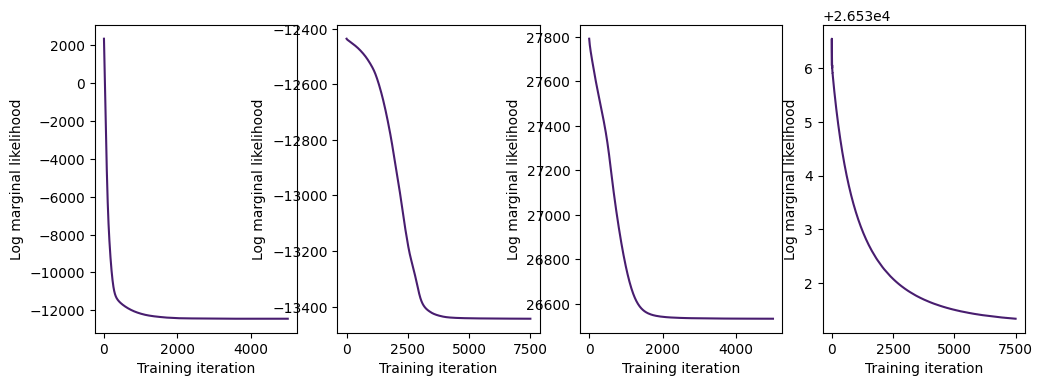

In [27]:
# Plot the loss evolution
fig, ax = plt.subplots(1, 4, figsize=(12, 4))

ax[0].plot(lls_noise_lfonly_fixed)
ax[0].set_xlabel("Training iteration")
ax[0].set_ylabel("Log marginal likelihood")

ax[1].plot(lls_noise_lfonly)
ax[1].set_xlabel("Training iteration")
ax[1].set_ylabel("Log marginal likelihood")

ax[2].plot(lls_noise_nargp_fixed)
ax[2].set_xlabel("Training iteration")
ax[2].set_ylabel("Log marginal likelihood")

ax[3].plot(lls_noise_nargp)
ax[3].set_xlabel("Training iteration")
ax[3].set_ylabel("Log marginal likelihood")

plt.show()


In [28]:
# Having trained the model, we'd like to sample from the posterior conditioned
# on observations. We'd like the samples to be at points other than the training
# inputs.
predictive_index_points_ = X_test


# NARGP kernel
optimized_kernel_h = get_nargp_kernel(
    scale_amplitude_0=scale_amplitude_var_0,
    scale_length_scale_0=scale_length_scale_var_0,
    interaction_amplitude_0=interaction_amplitude_var_0,
    interaction_length_scale_0=interaction_length_scale_var_0,
    bias_amplitude_0=bias_amplitude_var_0,
    bias_length_scale_0=bias_length_scale_var_0,
    linear_bias_amplitude_0=linear_bias_amplitude_var_0,
    linear_slope_amplitude_0=linear_slope_amplitude_var_0,
    linear_shift_0=linear_shift_var_0,
)

# L1 kernel
optimized_kernel_1 = get_lf_kernel(amplitude_var_1, length_scale_var_1)

## Passing information from low-fidelity node
# L1 index points : Used in the train index for NARGP
index_optimized_gprm_l1 = tfd.GaussianProcessRegressionModel(
    kernel=optimized_kernel_1,
    index_points=X_h,
    observation_index_points=X_l,
    observations=Y_l,
    observation_noise_variance=observation_noise_variance_var_1,
    predictive_noise_variance=np.float64(0.0),
)
# L1 predictive points : Used in the predict index for NARGP
optimized_gprm_l1 = tfd.GaussianProcessRegressionModel(
    kernel=optimized_kernel_1,
    index_points=predictive_index_points_,
    observation_index_points=X_l,
    observations=Y_l,
    observation_noise_variance=observation_noise_variance_var_1,
    predictive_noise_variance=np.float64(0.0),
)


In [29]:
## Combine information
## Using Irene Ji's full covariance method
num_samples = 50
ntest = predictive_index_points_.shape[0]

index_m1 = index_optimized_gprm_l1.sample(num_samples)
m1 = optimized_gprm_l1.sample(num_samples)

# Properly pass the uncertainty from L1 to H, and store the samples
tmp_m = np.zeros((num_samples, num_outputs_h, ntest))
tmp_v = np.zeros((num_samples, num_outputs_h, ntest))
tmp_sample = np.zeros((num_samples, num_outputs_h, ntest))
# This way you also account for the uncertainty from L1 node
for j in range(num_samples):
    index_points_h = make_nargp_index_points(
        m1=index_m1[j], X_h=X_h, num_outputs_h=num_outputs_h
    )

    predictive_index_points_h = make_nargp_index_points(
        m1=m1[j], X_h=predictive_index_points_, num_outputs_h=num_outputs_h
    )

    # Create the GP prior distribution, which we will use to train the model
    # parameters.
    nargp_gprm = tfd.GaussianProcessRegressionModel(
        kernel=optimized_kernel_h,
        index_points=predictive_index_points_h,
        observation_index_points=index_points_h,  ## observed index point might need to change
        observations=Y_h,
        observation_noise_variance=observation_noise_variance_var_0,
        predictive_noise_variance=np.float64(0.0),
    )

    # Properly account the uncertainty in each Monte Carlo sample
    tmp_m[j, :, :] = nargp_gprm.mean().numpy()
    tmp_v[j, :, :] = nargp_gprm.variance().numpy()
    tmp_sample[j, :, :] = nargp_gprm.sample().numpy()

# Average over samples
mu_final = np.mean(tmp_m, axis=0)
v_final = np.mean(tmp_v, axis=0) + np.var(tmp_m, axis=0)
y_pred = mu_final.T
var_pred = np.abs(v_final.T)

# # HF only
# h_gprm = tfd.GaussianProcessRegressionModel(
#     kernel=optimized_kernel_h,
#     index_points=predictive_index_points_,
#     observation_index_points=x_train_h,
#     observations=y_train_h[:, 0],
#     observation_noise_variance=observation_noise_variance_var_0,
#     predictive_noise_variance=np.float64(0.0),
# )

# h_samples = h_gprm.sample(num_samples)

# LF only
l1_gprm = tfd.GaussianProcessRegressionModel(
    kernel=optimized_kernel_1,
    index_points=predictive_index_points_,
    observation_index_points=X_l,
    observations=Y_l,
    observation_noise_variance=observation_noise_variance_var_1,
    predictive_noise_variance=np.float64(0.0),
)

l1_samples = l1_gprm.sample(num_samples)

In [30]:
y_pred.shape

(10, 96)

## Plot the predictions and examples


/var/folders/sn/b7hd1bmd569cjwgmtww4mv440000gn/T/ipykernel_52833/445653403.py:55: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in leg.legendHandles:


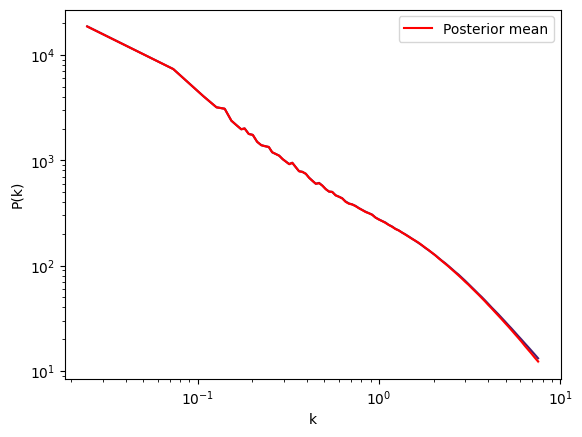

In [31]:
# plot the Pk comparison: GP predictions versus true Pk
test_i = 5

plt.loglog(10**kf, 10 ** (Y_test[:, test_i]))

plt.loglog(
    10**kf,
    10 ** (y_pred[test_i, :]),
    c="r",
    label="Posterior mean",
)
plt.fill_between(
    10**kf,
    10 ** (y_pred[test_i, :] - np.sqrt(var_pred[test_i, :])),
    10 ** (y_pred[test_i, :] + np.sqrt(var_pred[test_i, :])),
    color="r",
    alpha=0.2,
)


# plt.loglog(10**kf, 10 ** (Y_test[:, test_i] + Y_h_mean))

# plt.loglog(
#     10**kf,
#     10 ** (y_pred[test_i, :] + Y_h_mean),
#     c="r",
#     label="Posterior mean",
# )
# plt.fill_between(
#     10**kf,
#     10 ** (y_pred[test_i, :] - np.sqrt(var_pred[test_i, :]) + Y_h_mean),
#     10 ** (y_pred[test_i, :] + np.sqrt(var_pred[test_i, :]) + Y_h_mean),
#     color="r",
#     alpha=0.2,
# )


# plt.loglog(10**kf, 10 ** ((Y_test[:, test_i] + 1) * scalefactors))

# plt.loglog(
#     10**kf,
#     10 ** ((y_pred[test_i, :] + 1) * scalefactors),
#     c="r",
#     label="Posterior mean",
# )
# plt.fill_between(
#     10**kf,
#     10 ** ((y_pred[test_i, :] - np.sqrt(var_pred[test_i, :]) + 1) * scalefactors),
#     10 ** ((y_pred[test_i, :] + np.sqrt(var_pred[test_i, :]) + 1) * scalefactors),
#     color="r",
#     alpha=0.2,
# )

leg = plt.legend(loc="upper right")
for lh in leg.legendHandles:
    lh.set_alpha(1)
plt.xlabel(r"k")
plt.ylabel("P(k)")
plt.show()

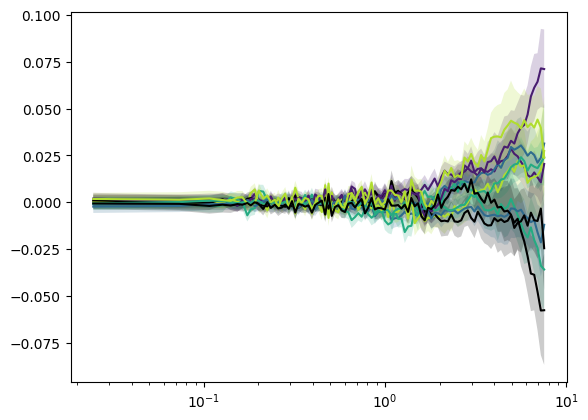

In [32]:
# plt.plot(10 ** (Y_test + Y_h_mean[:, None]) / 10 ** (mu_final + Y_h_mean[:, None]) - 1)

for i in range(Y_test.shape[1]):
    plt.semilogx(10**kf, 10 ** (Y_test[:, i]) / 10 ** (mu_final[:, i]) - 1)
    plt.fill_between(
        10**kf,
        10 ** (Y_test[:, i]) / 10 ** (mu_final[:, i] - np.sqrt(v_final[:, i])) - 1,
        10 ** (Y_test[:, i]) / 10 ** (mu_final[:, i] + np.sqrt(v_final[:, i])) - 1,
        alpha=0.2,
    )

# plt.plot(
#     10 ** ((Y_test + 1) * scalefactors[:, None])
#     / 10 ** ((mu_final + 1) * scalefactors[:, None])
#     - 1
# )


## Double check


In [33]:
# LF only
l1_gprm = tfd.GaussianProcessRegressionModel(
    kernel=optimized_kernel_1,
    index_points=X_l,
    observation_index_points=X_l,
    observations=Y_l,
    observation_noise_variance=observation_noise_variance_var_1,
    predictive_noise_variance=np.float64(0.0),
)

l1_mean = l1_gprm.mean()
l1_mean.shape

TensorShape([96, 60])

<tf.Tensor: shape=(96,), dtype=float64, numpy=
array([0.99944158, 0.99933199, 0.99924153, 1.00012365, 1.00013449,
       1.00014017, 0.99978989, 1.00016845, 1.00039153, 1.00093481,
       1.00077805, 1.00058574, 1.00026679, 1.00030704, 1.00082951,
       1.0010038 , 1.00098343, 1.0010573 , 1.00073922, 1.00045787,
       1.00050955, 1.0006522 , 1.0006704 , 1.00042696, 1.00042692,
       1.00068187, 1.00088321, 1.00046957, 1.00068697, 1.00097415,
       1.00080354, 1.00072082, 1.00093633, 1.00106458, 1.00108347,
       1.00144095, 1.00167174, 1.00225348, 1.00231338, 1.00311925,
       1.00393265, 1.00332137, 1.00312048, 1.0038931 , 1.00476672,
       1.00446358, 1.00317033, 1.0046675 , 1.00530284, 1.00786217,
       1.00576317, 1.00575045, 1.0062795 , 1.00674246, 1.00809091,
       1.00832807, 1.0065367 , 1.00641099, 1.00513094, 1.00416574,
       1.00468207, 1.00411755, 1.00479233, 1.00395191, 1.00388229,
       1.00381386, 1.00478396, 1.00488144, 1.00426474, 1.00502049,
       1.005803

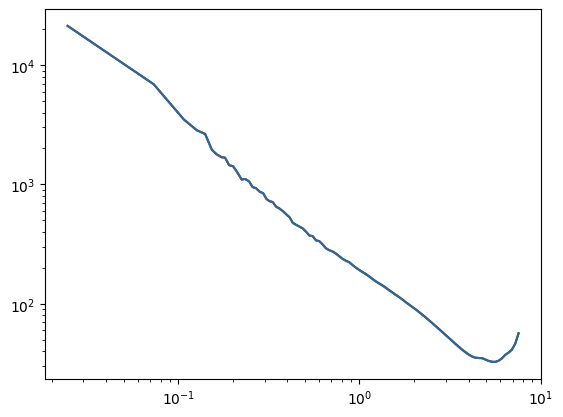

In [34]:
plt.loglog(10**kf, 10 ** (Y_l[:, 0] + Y_l_mean))
plt.loglog(10**kf, 10 ** (l1_mean[:, 0] + Y_l_mean))

10 ** (Y_l[:, 0] + Y_l_mean) / 10 ** (l1_mean[:, 0] + Y_l_mean)
